In [490]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import requests
import collections
import re
import pandas as pd
import os
from PIL import Image

In [2]:
# Plot style
sns.set()
%pylab inline
pylab.rcParams['figure.figsize'] = (4, 4)
# Avoid inaccurate floating values (for inverse matrices in dot product for instance)
# See https://stackoverflow.com/questions/24537791/numpy-matrix-inversion-rounding-errors
np.set_printoptions(suppress=True)

Populating the interactive namespace from numpy and matplotlib


In [3]:
%%html
<style>
.pquote {
  text-align: left;
  margin: 40px 0 40px auto;
  width: 70%;
  font-size: 1.5em;
  font-style: italic;
  display: block;
  line-height: 1.3em;
  color: #5a75a7;
  font-weight: 600;
  border-left: 5px solid rgba(90, 117, 167, .1);
  padding-left: 6px;
}
.notes {
  font-style: italic;
  display: block;
  margin: 40px 10%;
}
img + em {
  text-align: center;
  display: block;
  color: gray;
  font-size: 0.9em;
  font-weight: 600;
}
</style>

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
def plotVectors(vecs, cols, alpha=1):
    """
    Plot set of vectors.

    Parameters
    ----------
    vecs : array-like
        Coordinates of the vectors to plot. Each vectors is in an array. For
        instance: [[1, 3], [2, 2]] can be used to plot 2 vectors.
    cols : array-like
        Colors of the vectors. For instance: ['red', 'blue'] will display the
        first vector in red and the second in blue.
    alpha : float
        Opacity of vectors

    Returns:

    fig : instance of matplotlib.figure.Figure
        The figure of the vectors
    """
    plt.axvline(x=0, color='#A9A9A9', zorder=0)
    plt.axhline(y=0, color='#A9A9A9', zorder=0)

    for i in range(len(vecs)):
        if (isinstance(alpha, list)):
            alpha_i = alpha[i]
        else:
            alpha_i = alpha
        x = np.concatenate([[0,0],vecs[i]])
        plt.quiver([x[0]],
                   [x[1]],
                   [x[2]],
                   [x[3]],
                   angles='xy', scale_units='xy', scale=1, color=cols[i],
                  alpha=alpha_i)

$$
\newcommand\bs[1]{\boldsymbol{#1}}
$$

# Introduction
In this lesson, we will see yet another way to decompose (or factorize) matrices: the **Singular Value Decomposition** or **SVD**. In computer science, SVD is often used for data compression. In mathematics, it's handy for solving a system of linear equations. And for machine learning, SVD plays an important role in dimensionality reduction, which is often necessary to dispel the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality). In order to get the intuition behind SVD, we'll see each of these applications in turn.

# 3.8 Singular Value Decomposition
We saw in the last lesson that eigendecomposition only works for square matrices. When you can't decompose with eigendecomposition, you can use **Singular Value Decomposition** (SVD). But unlike  eigendecomposition, which decomposes a matrix into two matrices, with SVD we will decompose a matrix $\bs{M}$ into 3 matrices. The key intuition is that you can arrive at the same linear transformation embodied by $\bs{M}$ by applying each of the linear transformations embodied by the 3 resultant matrices.

<img src="images/singular-value-decomposition.png" width="300" alt="Illustration of the singular value decomposition" title="The singular value decomposition">
<em>The singular value decomposition</em>

#### A formal definition
>Suppose $\bs{M}$ is an $m \times n$ matrix whose entries come from the field $K$, which is either the field of real numbers or the field of complex numbers. Then there exists a factorization, called a singular value decomposition of $\bs{M}$, of the form

>$$\bs{M} = \bs{U} \bs{\Sigma } \bs{V}^{*}$$

>where

> - $\bs{U}$ is an $m \times m$ [unitary matrix](https://en.wikipedia.org/wiki/Unitary_matrix) over $K$ (if $K = \mathbb {R}$, unitary matrices are orthogonal matrices like we saw in lesson 3.6 Special Kinds of Matrices and Vectors)
> - $\bs{\Sigma}$ is a diagonal $m × n$ matrix with non-negative real numbers on the diagonal
> - $\bs{V}$ is an $n × n$ unitary matrix over $K$
> - $\bs{V}^{*}$ is the [conjugate transpose](https://en.wikipedia.org/wiki/Conjugate_transpose) of $\bs{V}$. When $K = \mathbb {R}$, $\bs{V}^{*}$ is the same as $\bs{V}^{T}$.

>The diagonal entries $\sigma_i$ of  $\bs{\Sigma}$ are known as the singular values of $\bs{M}$. 

That formal defition is a lot to swallow, so let's think of this visually. Since the beginning of these linear algebra lessons, we've emphasized the fact that you can visualize matrices as linear transformations in space. With the SVD, you decompose a matrix into three other matrices, each of which is itself a separate transformation. This is easiest to visualize in a $2$-dimensional space, where you can think of the SVD as the creation of three new matrices, each of which is a *sub-transformation* of the space. Generally speaking, the three transformations are:
 - a rotation 
 - followed by a scaling 
 - followed by another rotation

So let's see it with something simple, like the [unit circle](https://en.wikipedia.org/wiki/Unit_circle):

<img src="images/svd.gif"img>

#### More terminology
The columns of $\bs{U}$ are called the left-singular vectors of $\bs{M}$ while the columns of $\bs{V}$ are the right-singular vectors of $\bs{M}$. The values along the diagonal of $\bs{\Sigma}$ are the singular values of $\bs{M}$.

Here are the dimensions of the factorization:

<img src="images/singular-value-decomposition-understanding-dimensions.png" width="300" alt="Dimensions of the singular value decomposition (SVD)" title="The dimensions of the singular value decomposition (SVD)">
<em>The dimensions of the singular value decomposition</em>

Note that the diagonal matrix of singular values $\bs{\Sigma}$ has the same shape as $\bs{A}$.

# Intuition

To get the intuition behind the SVD, I'm going to remind you yet again that every matrix is a linear transformation. All that means is that any matrix, when applied to a vector, will do something to that vector. Decomposing that transformation into three sub-transformations - rotation, re-scaling, and another rotation - is the SVD. It's those three sub-transformations that correspond to the three matrices $\bs{U}$, $\bs{\Sigma}$, and $\bs{V}$.

### Every matrix can be seen as a linear transformation

Let's remind ourselves that any matrix can be seen as a specific linear transformation. When you *apply* a matrix to a vector or to another matrix you are simply applying the linear transformation embodied by the matrix. Let's see this in action with a diagonal matrix like $\bs{\Sigma}$ from our SVD formula. We'll see that this sort of linear transformation results in a **scaling**.

### Example 1.

We will modify the vector:

$$
\bs{v}=\begin{bmatrix}
    x\\\\
    y
\end{bmatrix}
$$

by applying the matrix:

$$
\begin{bmatrix}
    2 & 0\\\\
    0 & 2
\end{bmatrix}
$$

We will have:

$$
\begin{bmatrix}
    x'\\\\
    y'
\end{bmatrix}=\begin{bmatrix}
    2 & 0\\\\
    0 & 2
\end{bmatrix}
\begin{bmatrix}
    x\\\\
    y
\end{bmatrix}=
\begin{bmatrix}
    2x + 0y\\\\
    0x + 2y
\end{bmatrix}=
\begin{bmatrix}
    2x\\\\
    2y
\end{bmatrix}
$$

We see that applying the matrix:

$$
\begin{bmatrix}
    2 & 0\\\\
    0 & 2
\end{bmatrix}
$$

just scaled up (i.e. doubled) each coordinate of our vector. Here are the graphical representations of $\bs{v}$ and its transformation $\bs{w}$:

<img src="images/transformation-vector-by-matrix.png" width="400" alt="Plot of a vector and its transformation" title="The matrix increased both coordinates of the vector">
<em>Applying the matrix on the vector multiplied each coordinate by two</em>

### Example 2.

Let's now look at the unit circle to see how a diagonal matrix can rescale it. Recall that the unit circle represents the coordinates of every unit vector (i.e. vector of length 1).

<img src="images/unit-circle.png" width="200" alt="Representation of the unit circle" title="The unit circle">
<em>The unit circle</em>

Let's apply the same diagonal matrix from above

$$
\begin{bmatrix}
    2 & 0\\\\
    0 & 2
\end{bmatrix}
$$

to the unit circle:

$$
\begin{bmatrix}
    x'\\\\
    y'
\end{bmatrix}=
\begin{bmatrix}
    2 & 0\\\\
    0 & 2
\end{bmatrix}
\begin{bmatrix}
    x\\\\
    y
\end{bmatrix}=
\begin{bmatrix}
    2x\\\\
    2y
\end{bmatrix}
$$

<img src="images/unit-circle-transformation.png" width="400" alt="Representation of the unit circle and its transformation" title="The unit circle and its transformation">
<em>Another representation of the effect of the matrix: each coordinate of the unit circle was multiplied by two</em>

We can see that the matrix doubled the size of the circle. But in some transformations, the change applied to the $x$ coordinate is different from the change applied to the $y$ coordinate. Let's see this graphically.

### Example 3.

We will apply the matrix:

$$
\begin{bmatrix}
    3 & 0\\\\
    0 & 2
\end{bmatrix}
$$

to the unit circle:

$$
\begin{bmatrix}
    x'\\\\
    y'
\end{bmatrix}=
\begin{bmatrix}
    3 & 0\\\\
    0 & 2
\end{bmatrix}\cdot
\begin{bmatrix}
    x\\\\
    y
\end{bmatrix}=
\begin{bmatrix}
    3x\\\\
    2y
\end{bmatrix}
$$

This gives the following new circle:

<img src="images/unit-circle-transformation1.png" width="400" alt="Representation of the unit circle and its transformation" title="The unit circle and its transformation">
<em>This time the matrix didn't rescale each coordinate with the same weight</em>

#### A short proof of the linear transformation
>Let's verify that matrix transformation. Let's say that the coordinates of the new circle (after transformation) are $x'$ and $y'$. The relationship between the old coordinates ($x$, $y$) and the new coordinates ($x'$, $y'$) is:

>$$
\begin{bmatrix}
    x'\\\\
    y'
\end{bmatrix}=
\begin{bmatrix}
    3x\\\\
    2y
\end{bmatrix}
\Leftrightarrow
\begin{cases}
x=\frac{x'}{3}\\\\
y=\frac{y'}{2}
\end{cases}
$$

>In lesson 3.5, we saw that the norm of a unit vector is $1$. This tells us that the equation of the unit circle is $x^2+y^2=1$. By replacement, we end up with:

>$$
\begin{align*}
\left(\frac{x'}{3}\right)^2 + \left(\frac{y'}{2}\right)^2 = 1\\\\
\left(\frac{y'}{2}\right)^2 = 1 - \left(\frac{x'}{3}\right)^2\\\\
\frac{y'}{2} = \sqrt{1 - \left(\frac{x'}{3}\right)^2}\\\\
y' = 2\sqrt{1 - \left(\frac{x'}{3}\right)^2}
\end{align*}
$$

If we're for some reason not satisfied with the proof, we can plot the circles with Python. Here's how we should redefine the unit circle for plotting purposes.

$$
\begin{align*}
x^2+y^2=1\\\\
y^2=1-x^2\\\\
y=\sqrt{1-x^2}
\end{align*}
$$

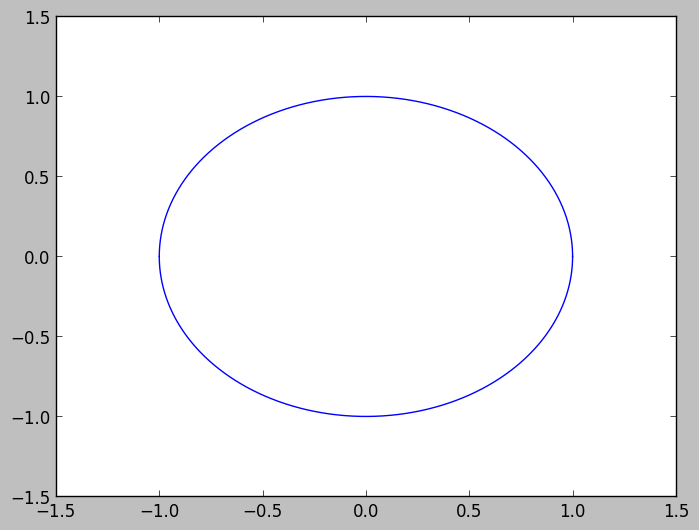

In [522]:
x = np.linspace(-1, 1, 100000)
y = np.sqrt(1-(x**2))
plt.plot(x, y, sns.color_palette().as_hex()[0])
plt.plot(x, -y, sns.color_palette().as_hex()[0])
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.show()

Alright, there's our unit circle!

> See this [discussion](https://stackoverflow.com/questions/32092899/plot-equation-showing-a-circle) on plotting circles if you're curious about the code above.

Now let's add the circle we obtained after transformation. We saw that it is defined as:

$$
y = 2\sqrt{1 - \left(\frac{x}{3}\right)^2}
$$

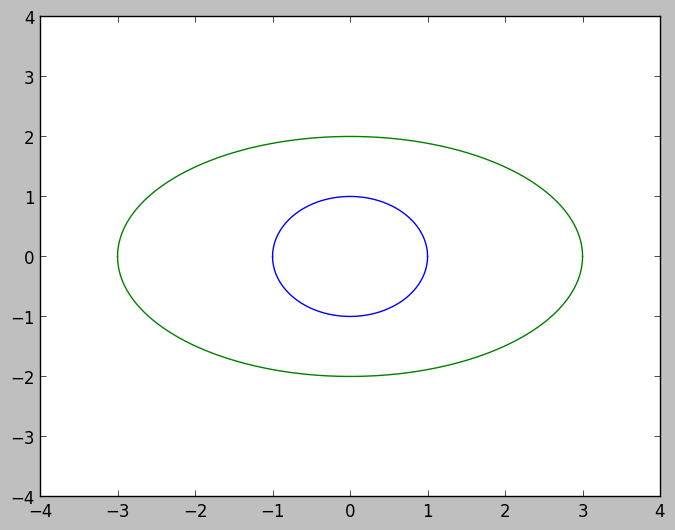

In [523]:
x1 = np.linspace(-3, 3, 100000)
y1 = 2*np.sqrt(1-((x1/3)**2))
plt.plot(x, y, sns.color_palette().as_hex()[0])
plt.plot(x, -y, sns.color_palette().as_hex()[0])
plt.plot(x1, y1, sns.color_palette().as_hex()[1])
plt.plot(x1, -y1, sns.color_palette().as_hex()[1])
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

This shows that our transformation was correct!

Note that these three examples all involved transformations with a **diagonal matrix**. In general, transformations with diagonal matrices result in a rescaling of each coordinate **without rotation**. 

If you can grok this, the you're a third of the way toward understanding SVD, since the matrix $\bs{\Sigma}$ is a diagonal matrix that corresponds to a rescaling without rotation.

### Example 4. rotation matrix

Matrices that are not diagonal can produce a rotation (see more details [here](https://en.wikipedia.org/wiki/Rotation_matrix)). That's the function of $\bs{U}$ and $\bs{V}$ in $\bs{M} = \bs{U} \bs{\Sigma } \bs{V}^{*}$. 

Since it is easier to think about angles when we talk about rotation, we will use a matrix of the form:

$$
R=
\begin{bmatrix}
    cos(\theta) & -sin(\theta)\\\\
    sin(\theta) & cos(\theta)
\end{bmatrix}
$$

This matrix will rotate our vectors or matrices counterclockwise through an angle $\theta$. Our new coordinates will be

$$
\begin{bmatrix}
    x'\\\\
    y'
\end{bmatrix}=
\begin{bmatrix}
    cos(\theta) & -sin(\theta)\\\\
    sin(\theta) & cos(\theta)
\end{bmatrix}
\begin{bmatrix}
    x\\\\
    y
\end{bmatrix}=
\begin{bmatrix}
    xcos(\theta) - ysin(\theta)\\\\
    xsin(\theta) + ycos(\theta)
\end{bmatrix}
$$

Let's rotate some vectors through an angle of $\theta = 45^\circ$.

Let's start with the vector $\bs{u}$ of coordinates $x=0$ and $y=1$ and the vector $\bs{v}$ of coordinates $x=1$ and $y=0$. The vectors $\bs{u'}$ $\bs{v'}$ are the rotated vectors.

<img src="images/unit-vectors-rotation.png" width="200" alt="Rotation of the unit vectors through matrix operation" title="Rotation of the unit vectors">
<em>Counter clockwise rotation of the unit vectors with $\theta = 45^\circ$</em>

First, let's plot $\bs{u}$ and $\bs{v}$.

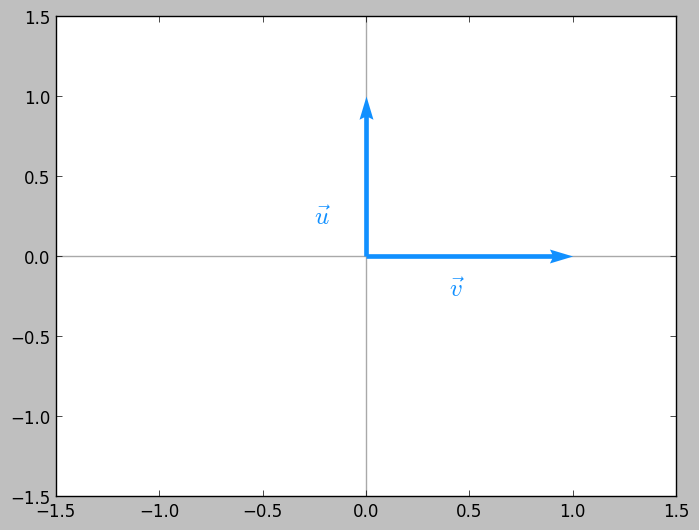

In [521]:
orange = '#FF9A13'
blue = '#1190FF'
    
u = [1,0]
v = [0,1]

plotVectors([u, v], cols=[blue, blue])

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

plt.text(-0.25, 0.2, r'$\vec{u}$', color=blue, size=18)
plt.text(0.4, -0.25, r'$\vec{v}$', color=blue, size=18)
plt.show()

They are the <a href="https://en.wikipedia.org/wiki/Basis_(linear_algebra)">basis vectors</a> of our space. We will now calculate each of these transformations:

$$
\begin{cases}
u_x = 0\cdot cos(45) - 1\cdot sin(45)\\\\
u_y = 0\cdot sin(45) + 1\cdot cos(45)
\end{cases}
\Leftrightarrow
\begin{cases}
u_x = -sin(45)\\\\
u_y = cos(45)
\end{cases}
$$

$$
\begin{cases}
v_x = 1\cdot cos(45) - 0\cdot sin(45)\\\\
v_y = 1\cdot sin(45) + 0\cdot cos(45)
\end{cases}
\Leftrightarrow
\begin{cases}
v_x = cos(45)\\\\
v_y = sin(45)
\end{cases}
$$

And now we'll plot these new vectors to check that they are actually a rotated version of our basis vectors (rotated through an angle of $45^\circ$).

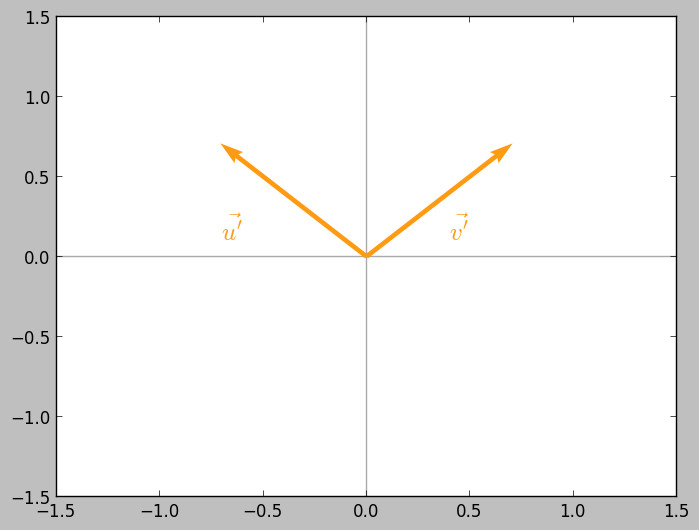

In [520]:
u1 = [-np.sin(np.radians(45)), np.cos(np.radians(45))]
v1 = [np.cos(np.radians(45)), np.sin(np.radians(45))]

plotVectors([u1, v1], cols=[orange, orange])
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

plt.text(-0.7, 0.1, r"$\vec{u'}$", color=orange, size=18)
plt.text(0.4, 0.1, r"$\vec{v'}$", color=orange, size=18)
plt.show()

> *numpy tip:* the numpy functions `sin` and `cos` take input in radians. We can convert our angle from degrees to radians with the function `np.radians()`.

We can also rotate a circle. But in order to see the rotaiton, we'll take the rescaled circle from example 3.

<img src="images/rescaled-circle-rotated.png" width="300" alt="A rescaled circle (not the same hight and width) rotated" title="Rescaled circle rotated">
<em>The effect of a rotation matrix on a rescaled circle</em>

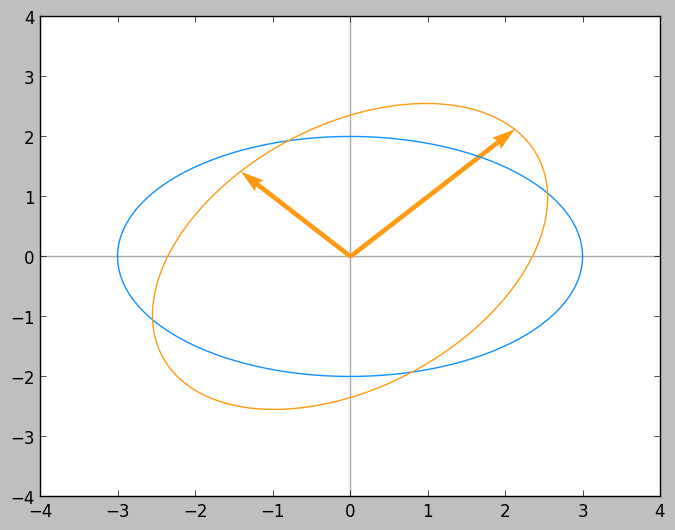

In [524]:
x = np.linspace(-3, 3, 100000)
y = 2*np.sqrt(1-((x/3)**2))

x1 = x*np.cos(np.radians(45)) - y*np.sin(np.radians(45))
y1 = x*np.sin(np.radians(45)) + y*np.cos(np.radians(45))

x1_neg = x*np.cos(np.radians(45)) - -y*np.sin(np.radians(45))
y1_neg = x*np.sin(np.radians(45)) + -y*np.cos(np.radians(45))

u1 = [-2*np.sin(np.radians(45)), 2*np.cos(np.radians(45))]
v1 = [3*np.cos(np.radians(45)), 3*np.sin(np.radians(45))]

plotVectors([u1, v1], cols=['#FF9A13', '#FF9A13'])

plt.plot(x, y, '#1190FF')
plt.plot(x, -y, '#1190FF')

plt.plot(x1, y1, '#FF9A13')
plt.plot(x1_neg, y1_neg, '#FF9A13')

plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

We can see that the circle has been rotated by an angle of $45^\circ$. We have chosen the length of the vectors from the rescaling weight from example 3 (factor 3 and 2) to match the circle.

### Examples summary

The examples were meant to show you how vectors and matrices can be transformed with rotating and/or scaling matrices. The SVD is the decomposition of one complex transformation into 3 simpler transformations (a rotation, a scaling, and another rotation).

>Note that we were only working with square matrices and real numbers. The SVD can be done with non-square matrices and complex numbers, but visualizing that stuff would have been tough or impossible. For instance, a $3 \times 2$ matrix will map a 2D space to a 3D space.

><img src="images/non-square-matrix-change-dimensions.png" width="250" alt="A non square matrix change the number of dimensions of the input" title="Example of a change of dimensions">
<em>A non square matrix change the number of dimensions of the input</em>

# The three SVD transformations

Now that the link between matrices and linear transformation is clearer, we can check that a transformation associated with a matrix can in fact be decomposed with the help of the SVD.

But first let's create a function that takes a 2D matrix as an input and draws the unit circle transformation when we apply this matrix to it. It will be useful to visualize the transformations.

In [525]:
def matrixToPlot(matrix, vectorsCol=['#FF9A13', '#1190FF']):
    """
    Modify the unit circle and basis vector by applying a matrix.
    Visualize the effect of the matrix in 2D.

    Parameters
    ----------
    matrix : array-like
        2D matrix to apply to the unit circle.
    vectorsCol : HEX color code
        Color of the basis vectors

    Returns:

    fig : instance of matplotlib.figure.Figure
        The figure containing modified unit circle and basis vectors.
    """
    # Unit circle
    x = np.linspace(-1, 1, 100000)
    y = np.sqrt(1-(x**2))
    
    # Modified unit circle (separate negative and positive parts)
    x1 = matrix[0,0]*x + matrix[0,1]*y
    y1 = matrix[1,0]*x + matrix[1,1]*y
    x1_neg = matrix[0,0]*x - matrix[0,1]*y
    y1_neg = matrix[1,0]*x - matrix[1,1]*y
    
    # Vectors
    u1 = [matrix[0,0],matrix[1,0]]
    v1 = [matrix[0,1],matrix[1,1]]
    
    plotVectors([u1, v1], cols=[vectorsCol[0], vectorsCol[1]])

    plt.plot(x1, y1, 'g', alpha=0.5)
    plt.plot(x1_neg, y1_neg, 'g', alpha=0.5)

We'll use this function to check that the three transformations given by the SVD are equivalent to the transformation done with the original matrix. We will also draw each step of the SVD to see the independant effects of the first rotation, the scaling, and finally the second rotation.

We will use the matrix:

$$
\bs{A}=\begin{bmatrix}
    3 & 7\\\\
    5 & 2
\end{bmatrix}
$$

and plot the unit circle and its transformation by $\bs{A}$:

Unit circle:


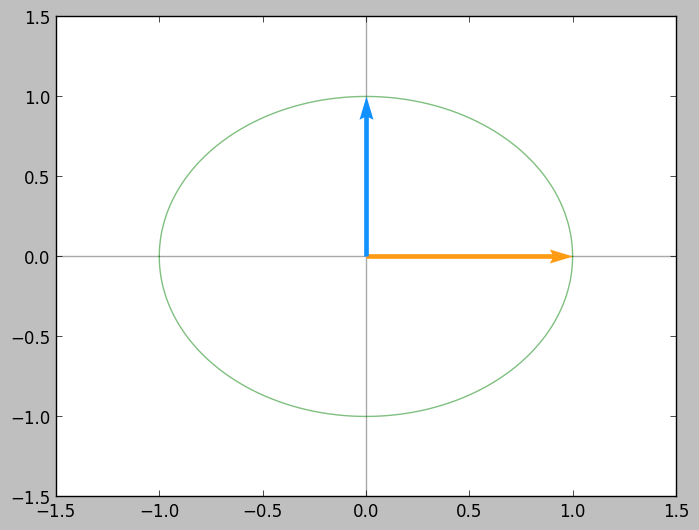

Unit circle transformed by A:


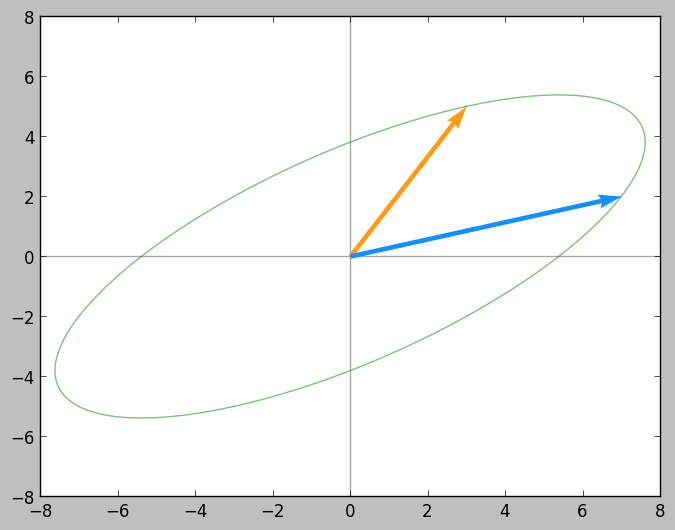

In [526]:
A = np.array([[3, 7], [5, 2]])

print('Unit circle:')
matrixToPlot(np.array([[1, 0], [0, 1]]))
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.show()

print('Unit circle transformed by A:')
matrixToPlot(A)
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.show()

This is what we get when we apply the matrix $\bs{A}$ to the unit circle and its basis vectors. We can see that the two base vectors are not necessarily rotated the same way. This is related to the sign of the **determinent** of the matrix, which is a topic we'll reach in lesson 3.11.

Let's now compute the SVD of $\bs{A}$:

In [527]:
U, Sigma, V = np.linalg.svd(A)
U

array([[-0.85065081, -0.52573111],
       [-0.52573111,  0.85065081]])

In [528]:
Sigma

array([ 8.71337969,  3.32821489])

In [529]:
V

array([[-0.59455781, -0.80405286],
       [ 0.80405286, -0.59455781]])

> Note that $\bs{V}$ was returned by numpy **already transposed** (see the [doc](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.svd.html)).

Now that we have $\bs{U}$, $\bs{\Sigma}$ and $\bs{V}$, we can look individually at the effect of each of these sub-transformations. 

Unit circle:


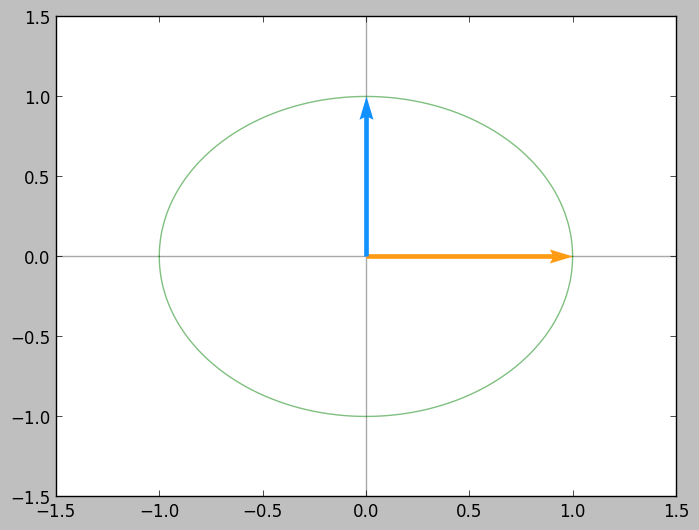

First rotation with V:


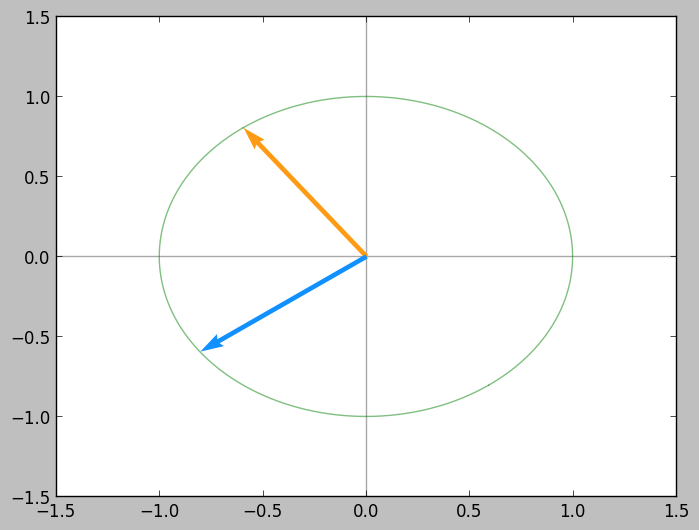

Scaling with Sigma*V:


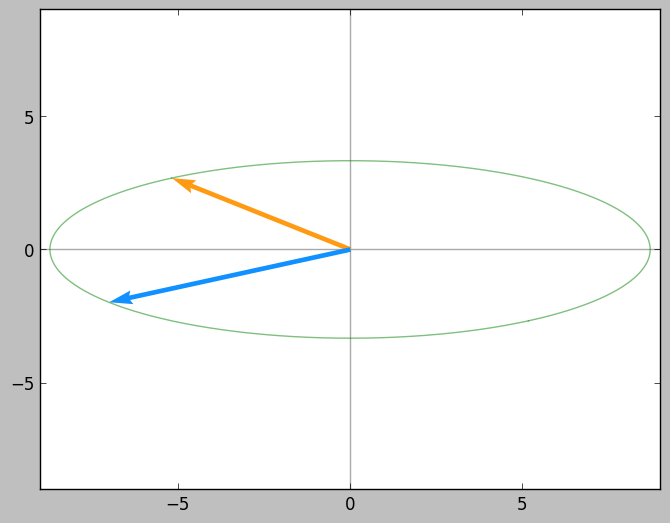

Second rotation with U*Sigma*V


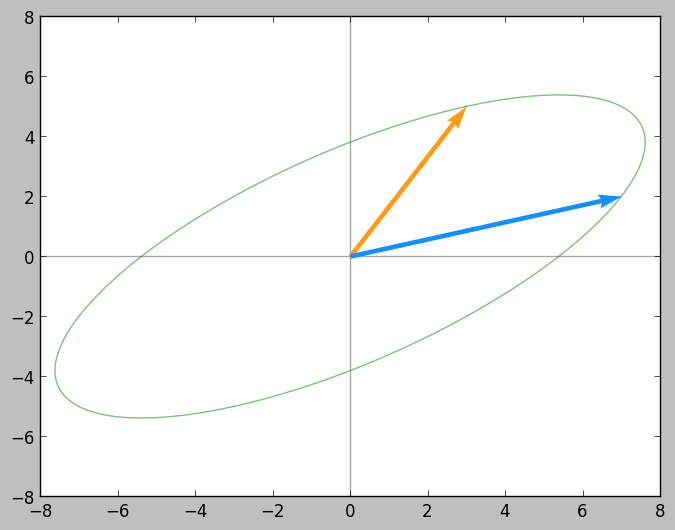

In [530]:
# Unit circle
print('Unit circle:')
matrixToPlot(np.array([[1, 0], [0, 1]]))
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.show()

print('First rotation with V:')
matrixToPlot(V)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.show()

print('Scaling with Sigma*V:')
matrixToPlot(np.diag(Sigma).dot(V))
plt.xlim(-9, 9)
plt.ylim(-9, 9)
plt.show()

print('Second rotation with U*Sigma*V')
matrixToPlot(U.dot(np.diag(Sigma)).dot(V))
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.show()

This last step is the same as the transformation of $\bs{A}$ we got earlier.

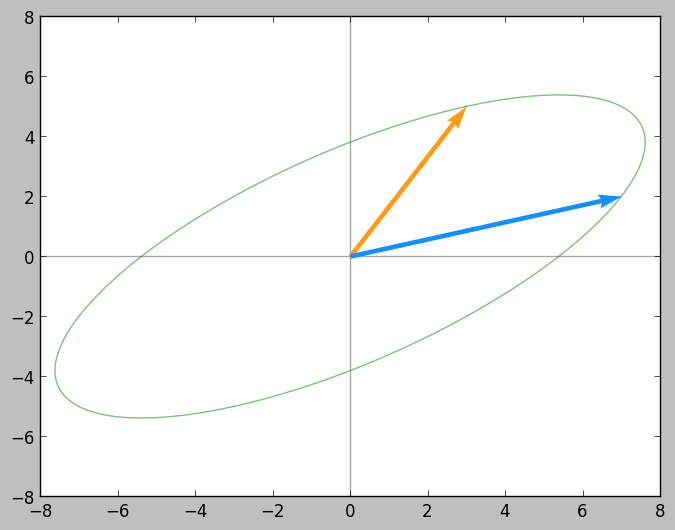

In [531]:
matrixToPlot(A)
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.show()

# Singular values interpretation

The singular values $\sigma_1 \cdots \sigma_i$ located in the diagonal of $\bs{\Sigma}$ are typically ordered in descending order and correspond to a new set of features, with the first feature, $\sigma_1$, explaining the most variance involved with the matrix. 

To see how this variance is explained by the largest singular value, we'll look again at the last example. We'll see that the [major axis](https://en.wikipedia.org/wiki/Semi-major_and_semi-minor_axes) of the elipse is the first left singular vector ($u_1$) and its norm will be the first singular value ($\sigma_1$).

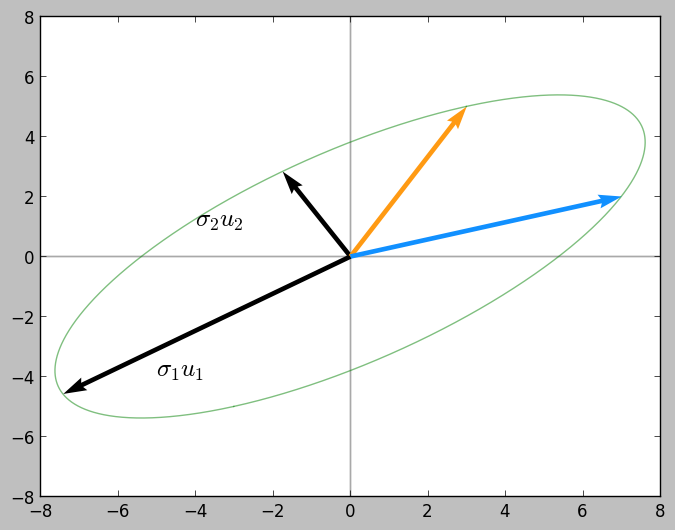

In [532]:
u1 = [D[0]*U[0,0], D[0]*U[0,1]]
v1 = [D[1]*U[1,0], D[1]*U[1,1]]

plotVectors([u1, v1], cols=['black', 'black'])

matrixToPlot(A)

plt.text(-5, -4, r"$\sigma_1u_1$", size=18)
plt.text(-4, 1, r"$\sigma_2u_2$", size=18)

plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.show()

Above, you see in bold the major ($\sigma_1u_1$) and minor ($\sigma_2u_2$) axes of the elipse. We can see quite naturally that the feature corresponding to the major axis is associated with the most variance (i.e. the range of values on this major axis is bigger than range of the minor axis). We'll dive deeper into this interesting result of the SVD in a moment when we explore the curse of dimensionality.

# SVD and eigendecomposition

Now that we have an idea of SVD, let's see how those individual sub-transformations are found.

The matrices $\bs{U}$, $\bs{\Sigma}$ and $\bs{V}$ can be found by transforming $\bs{M}$ into a square matrix and computing the eigenvectors of this square matrix. The square matrix can be obtained by multiplying the matrix $\bs{M}$ by its transpose in multiple ways:

- $\bs{U}$ corresponds to the eigenvectors of $\bs{MM}^\text{T}$
- $\bs{V}$ corresponds to the eigenvectors of $\bs{M^\text{T}M}$
- $\bs{D}$ corresponds to the eigenvalues $\bs{MM}^\text{T}$ or $\bs{M^\text{T}M}$ which are the same.

As an example, let's look at a non-square matrix:

$$
\bs{M}=\begin{bmatrix}
    7 & 2\\\\
    3 & 4\\\\
    5 & 3
\end{bmatrix}
$$

The singular value decomposition can be done with the `linalg.svd()` function from Numpy (note that `np.linalg.eig(M)` works only on square matrices and will give an error for `M`).

In [533]:
M = np.array([[7, 2], [3, 4], [5, 3]])
U, Sigma, V = np.linalg.svd(M)
U

array([[-0.69366543,  0.59343205, -0.40824829],
       [-0.4427092 , -0.79833696, -0.40824829],
       [-0.56818732, -0.10245245,  0.81649658]])

In [534]:
Sigma

array([ 10.25142677,   2.62835484])

In [535]:
V

array([[-0.88033817, -0.47434662],
       [ 0.47434662, -0.88033817]])

## The left-singular values

The left-singular values of $\bs{M}$ correspond to the eigenvectors of $\bs{MM}^\text{T}$.

### Example 5.
>Note that the sign difference comes from the fact that eigenvectors are not unique. The `linalg` functions from numpy return the normalized eigenvectors. Scaling by `-1` doesn't change their direction or the fact that they are unit vectors.

In [536]:
U, Sigma, V = np.linalg.svd(M)

Left singular vectors of M:

In [537]:
U

array([[-0.69366543,  0.59343205, -0.40824829],
       [-0.4427092 , -0.79833696, -0.40824829],
       [-0.56818732, -0.10245245,  0.81649658]])

Eigenvectors of $MM^T$:

In [538]:
np.linalg.eig(M.dot(M.T))[1]

array([[-0.69366543, -0.59343205, -0.40824829],
       [-0.4427092 ,  0.79833696, -0.40824829],
       [-0.56818732,  0.10245245,  0.81649658]])

## The right-singular values

The right-singular values of $\bs{M}$ correspond to the eigenvectors of $\bs{M}^\text{T}\bs{M}$.

### Example 6.

In [539]:
U, Sigma, V = np.linalg.svd(M)

Right singular vectors of A:

In [540]:
V

array([[-0.88033817, -0.47434662],
       [ 0.47434662, -0.88033817]])

Eigenvectors of $M^{T}M$:

In [541]:
np.linalg.eig(M.T.dot(M))[1]

array([[ 0.88033817, -0.47434662],
       [ 0.47434662,  0.88033817]])

## The nonzero singular values

The nonzero singular values of $\bs{M}$ are the square roots of the eigenvalues of $\bs{M}^\text{T}\bs{M}$ and $\bs{MM}^\text{T}$.

### Example 7.

In [542]:
U, Sigma, V = np.linalg.svd(M)
Sigma

array([ 10.25142677,   2.62835484])

Eigenvalues of $M^{T}M$:

In [543]:
np.linalg.eig(M.T.dot(M))[0]

array([ 105.09175083,    6.90824917])

Eigenvalues of $MM^{T}$:

In [544]:
np.linalg.eig(M.dot(M.T))[0]

array([ 105.09175083,    6.90824917,    0.        ])

Square root of the eigenvalues:

In [545]:
np.sqrt(np.linalg.eig(M.T.dot(M))[0])

array([ 10.25142677,   2.62835484])

# SVD Applications
Now we'll see how the SVD can be used to compress images (which is a form of dimensionality reduction), fit a line to linear data points, and reduce the number of dimensions in a dataset.


## Image Compression 

In this example, we will use the SVD to extract the most important features from an image. This process is similar to using SVD to remove noisy dimensions from a large dataset (that'll be the third example). The benefit here is that you will actually see the effect of the SVD. The code is inspired/taken from [this blog post](https://www.frankcleary.com/svdimage/).

Let's start by loading an image into Python and then converting it to a numpy array. Recall this is something we did much earlier in the series when we first introduced ourselves to numy. 

> Note that, to keep things simple, Wwe will convert the image to grayscale so as to have just one dimension per pixel. The shape of the matrix corresponds to the dimension of the image filled with intensity values: 1 cell per pixel.

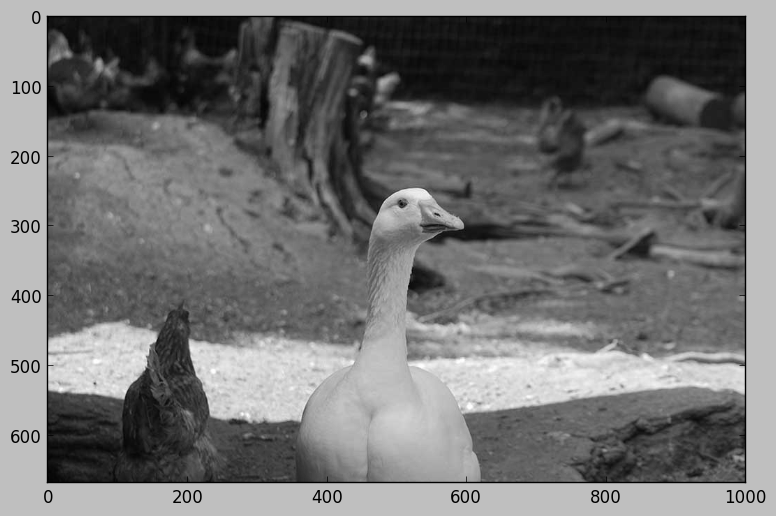

In [546]:
plt.style.use('classic')
img = Image.open('test_svd.jpg')
# convert image to grayscale
imggray = img.convert('LA')
# convert to numpy array
imgmat = np.array(list(imggray.getdata(band=0)), float)
# Reshape according to orginal image dimensions
imgmat.shape = (imggray.size[1], imggray.size[0])

plt.figure(figsize=(9, 6))
plt.imshow(imgmat, cmap='gray')
plt.show()

To start, let's extract the left singular vectors, the singular values, and the right singular vectors:

In [547]:
U, Sigma, V = np.linalg.svd(imgmat)

Let's check the shapes of our matrices:

In [548]:
imgmat.shape

(669, 1000)

In [549]:
U.shape

(669, 669)

In [550]:
Sigma.shape

(669,)

In [551]:
V.shape

(1000, 1000)

Remember that $\bs{\Sigma}$ contains the singular values that need to be put into a diagonal matrix. Also, $\bs{V}$ doesn't need to be transposed by us (see above on how numpy already did that for us).

The singular vectors and singular values are ordered such that their first values represent the greatest amount of variance. For this reason, using just the first few singular vectors and singular values will provide the greatest partial reconstruction of the principal elements of the image.

To see this, we'll try to reconstruct the image using fewer than the total number of singular values. For instance, with 2 singular values we will have:

<img src="images/dimensions-reconstruction-image-singular-value-decomposition.png" width="400" alt="The dimensions of singular value decomposition to reconstruct image from few components" title="Image reconstruction dimensions">
<em>We can reconstruct the image from few components</em>

In this example, we have reconstructed the 669px by 1000px image from two singular values. 

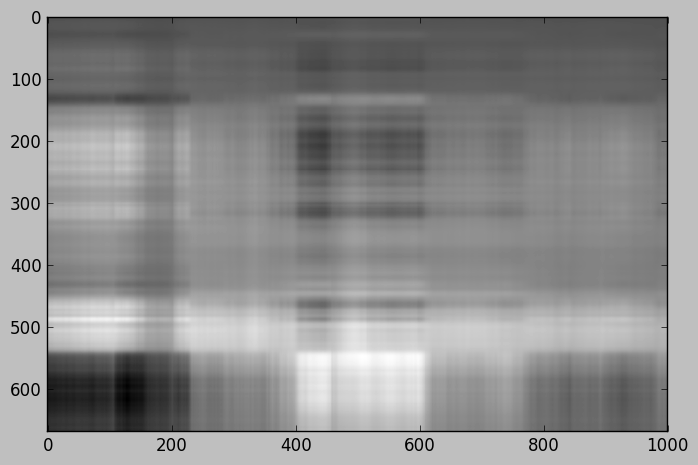

In [552]:
reconstimg = np.matrix(U[:, :2]) * np.diag(D[:2]) * np.matrix(V[:2, :])
plt.imshow(reconstimg, cmap='gray')
plt.show()

It kind of hard to see Lucy with only two singular values and singular vectors. But we can at least see some vague shapes and outlines.

Let's now use a loop to see what happens when we slowly increment the number of singular values.

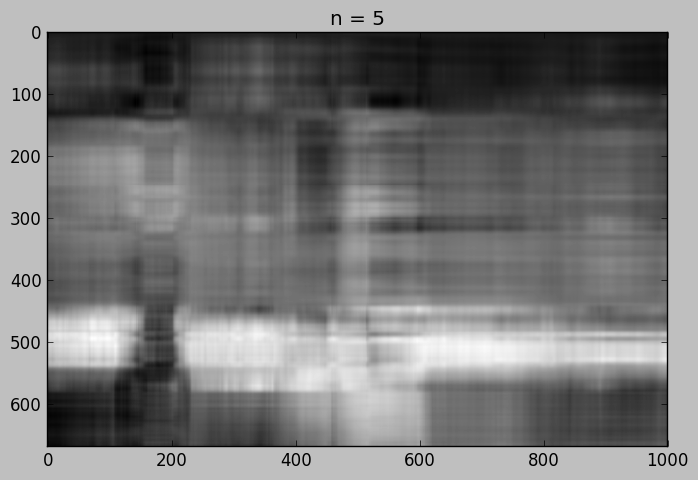

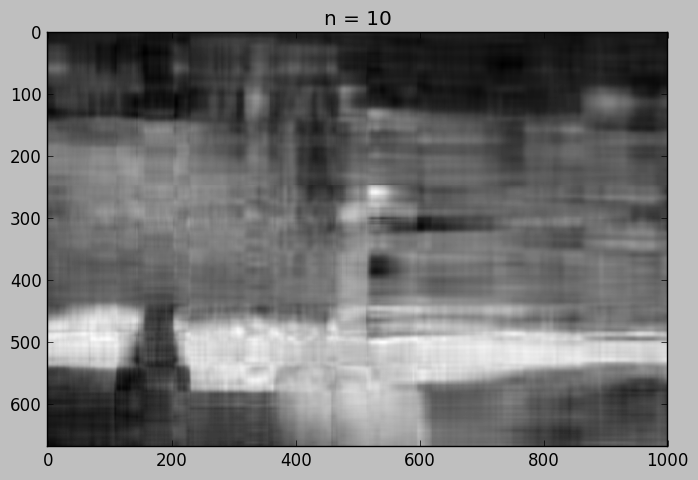

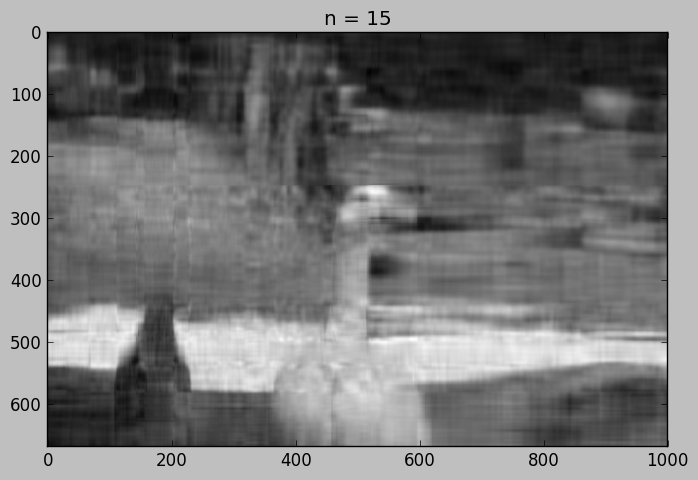

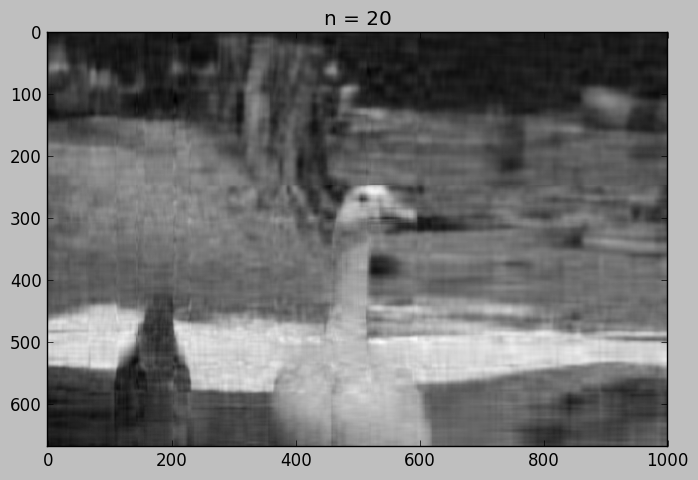

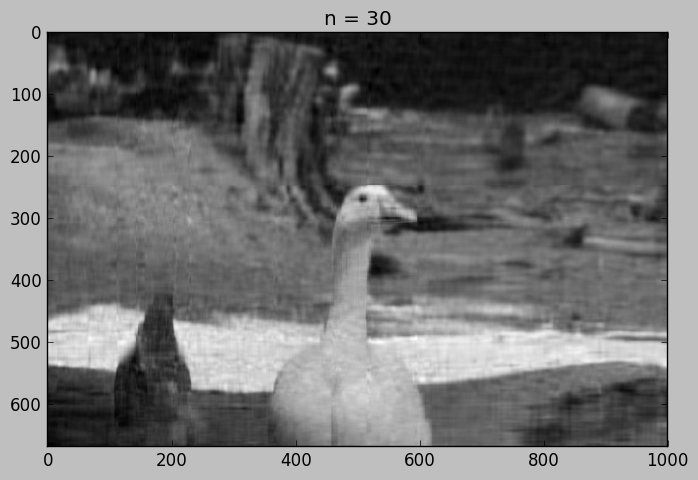

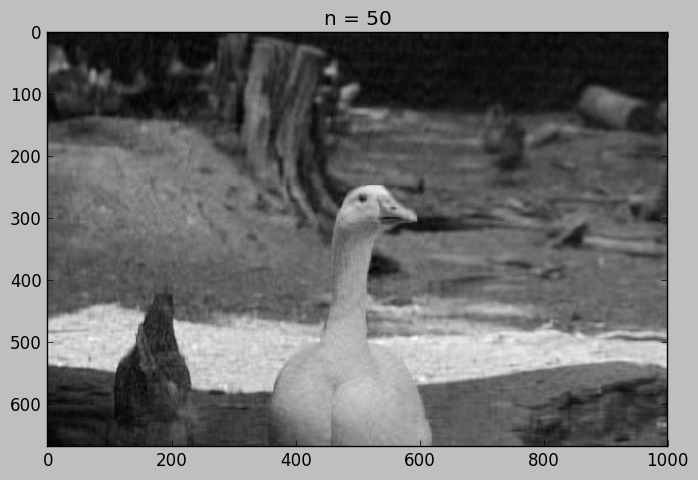

In [553]:
for i in [5, 10, 15, 20, 30, 50]:
    reconstimg = np.matrix(U[:, :i]) * np.diag(Sigma[:i]) * np.matrix(V[:i, :])
    plt.imshow(reconstimg, cmap='gray')
    title = "n = %s" % i
    plt.title(title)
    plt.show()

At 50 components, we have a pretty decent quality image!

## Solving Linear Equations
The SVD can also be used to solve linear equations. And in those cases where the equation has no solution, the SVD can be used to find a line that best fits the function. For this example, we'll take up the latter problem.

### Generate some dummy data
Suppose we collect some data on two variables, $x$ and $y$, and it's our job to best describe the relationship between these two variables. Let's say the data looks like this when plotted:

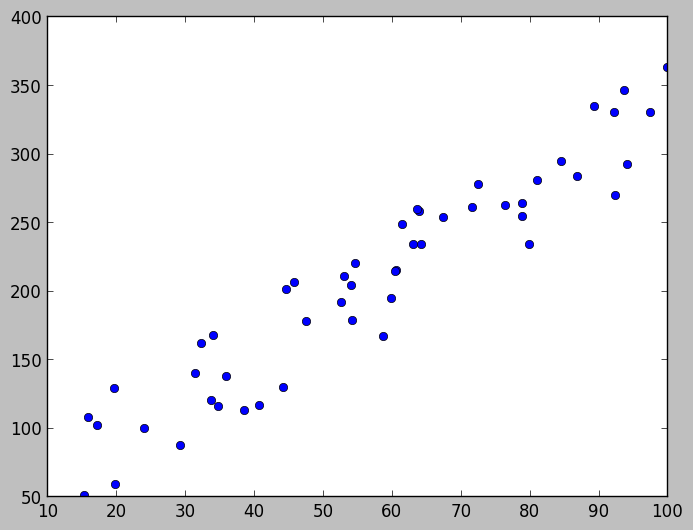

In [554]:
#Generate some points around a line
intercept = -10
slope = 3;
npts = 50
noise = 80
xs = 10 + np.random.uniform(0,1,size=npts) * 90
ys = slope * xs + intercept + np.random.uniform(0,1,size=npts) * noise
fig, ax = plt.subplots()
ax.plot(xs, ys, 'o')

Each point above is an $(x_i,y_i)$ pair. Our hypothesis is that these points are related by some linear equation $ax_i + by_i = c$, since the relationship looks pretty linear in that graph. Equivalently, $ax_i + by_i - c = 0$, or, in matrix form:

$$a\begin{bmatrix}x_1 \\ x_2 \\ \vdots \\ x_n\end{bmatrix} + b\begin{bmatrix}y_1 \\ y_2 \\ \vdots \\
y_n\end{bmatrix} + c\begin{bmatrix}-1 \\ -1 \\ \vdots \\ -1\end{bmatrix} = \begin{bmatrix}
x_1 & y_1 & -1 \\ x_2 & y_2 & -1 \\ \vdots & \vdots & \vdots \\ x_n & y_n & -1 \\
\end{bmatrix}\begin{bmatrix}a \\ b \\ c\end{bmatrix} = \textbf{0}$$

Now that we have our data in a matrix $\bs{A}$, and our variables in some vector $\bs{x}$, we can write this problem in the more familiar matrix form as $\bs{A}\bs{x}=0$, where we’d like to figure out what $\bs{x}$ is given $\bs{A}$. But in this example, we have more data than variables, which means that we can’t solve our system using a typical approach. We can, however, fit $\bs{x}$ to $\bs{A}$ in order to minimize the value of $\bs{A}\bs{x}$. And we'll do this with the SVD!

### Minimizing $\bs{A}\bs{x}$
So let's consider our data matrix:

$$A = \begin{bmatrix}
        x_1 & y_1 & -1 \\ x_2 & y_2 & -1 \\ \vdots & \vdots & \vdots \\ x_n & y_n & -1 \\
\end{bmatrix}.$$

and also $\bs{x}$

$$x = \begin{bmatrix}a \\ b \\ c\end{bmatrix}$$

#### The theory
Our task is to minimize the value of $\bs{A}\bs{x}$. Note that it looks like we could do this super easily by making $a, b, \text{and } c$ arbitrarily small. But if we make $a, b, \text{and } c$ infinitely close to $0$, then we would be making $\bs{A}\bs{x}$ smaller and smaller until the end of time. That's not a helpful or meaningful approach, so to reframe the problem we'll scale $\begin{bmatrix}a & b & c\end{bmatrix}$ so that it is [unit normal](https://en.wikipedia.org/wiki/Unit_vector) (namely, $\sqrt{a^2 + b^2 + c^2} = 1$). Using this constraint is a neat trick that enables us to use the SVD, since the columns of $U$ and $V$ in the SVD formula are orthonormal vectors, which can be regarded as basis vectors. The fact that unit vectors are often chosen to form the basis of a vector space - and that every vector in that space may be written as a linear combination of unit vectors - means that we can use a column from $V$ to get our optimal values for $a, b, \text{and } c$!

#### The intuition
Suppose we take the SVD of $\bs{A}$ to get $A = U\Sigma V^T$. If the equation $\bs{A}\bs{x}=0$ can be solved exactly, then at least one of the eigenvalues of $\bs{A}$ must be zero, which in turn means that one of the eigenvalues of $AA^T$ must be zero, and therefore one of the singular values must be zero. So, if one of the elements on the diagonal of $\Sigma$ is zero, then we have an exact solution. The column of that solution in $\bs{\Sigma}$ then corresponds to a column of $V$ that has our values for $a, b, \text{and } c$. In short, we just look for a zero-valued singular value, take the corresponding column of $V$, and then we have our solution! 
> Note that if we have two zero singular values, that just means that we have multiple solutions to our equation, and the system of equations is under-determined.

If none of the singular values are zero, then the equation doesn't have a solution. This is our case since we have an over-determined system. But that doesn't mean we cant find a solution that minimizes the output of the equation. Although it’s slightly tricky to prove this, I think you’ll find it very intuitive that the smallest singular value actually corresponds to the this optimal (i.e. minimized) solution. Namely, if you want to find the best ([least squares fit](https://en.wikipedia.org/wiki/Least_squares)) to the data, simply look at the smallest (usually, last) singular value, take the corresponding column of $V$, and then read off your values for $a,b, \text{and }c$. Let's see that in action! 

In [555]:
#our xs and ys are already defined
xs

array([ 99.97347913,  54.24232292,  72.44999407,  63.8828597 ,
        19.78379224,  71.64192955,  40.76391153,  78.89802048,
        38.54739018,  52.55805378,  84.59078593,  63.62827386,
        60.66221914,  93.68338342,  59.87382253,  89.35679223,
        23.96088862,  53.1084544 ,  35.91348605,  15.91594538,
        63.00890675,  86.80067357,  60.43356304,  17.22360174,
        31.43251879,  92.37681808,  19.73543351,  64.17945762,
        94.18367867,  81.0410377 ,  78.86465841,  29.2529161 ,
        33.79332073,  15.31941006,  92.21272664,  47.55262333,
        32.2719079 ,  34.06304657,  34.77504607,  67.38954331,
        54.68446411,  44.18279992,  44.6208917 ,  79.90209571,
        76.39735462,  61.53581512,  97.47500175,  45.85348517,
        58.67804882,  54.07260816])

In [556]:
ys

array([ 363.07848448,  178.49320023,  277.59314642,  257.79605576,
         58.9954457 ,  260.91157233,  116.50420657,  254.36462831,
        112.77279971,  191.9697748 ,  294.76029845,  259.69508516,
        214.83461742,  346.34695901,  194.39481481,  334.56224283,
         99.8226668 ,  210.52173052,  137.82118382,  108.00457715,
        234.32589544,  283.73589754,  214.25054782,  101.73069185,
        140.32706515,  269.68606705,  128.72948335,  234.15687702,
        292.22409662,  280.42731381,  263.87286738,   87.77771056,
        120.45477405,   50.87167324,  330.5061556 ,  178.10267959,
        162.10249708,  168.015923  ,  116.07053997,  253.73512735,
        219.99901263,  129.69402576,  201.03719888,  234.08308975,
        262.40197628,  248.34276631,  330.60451083,  206.26499901,
        167.24561189,  204.28694715])

In [558]:
# create a vector full of negative 1s 
ones = np.full(xs.shape,-1,dtype=float64)

In [559]:
# create matrix A
A = np.column_stack((xs,ys,ones))

In [560]:
#get U, Sigma and V using np.linalg.svd
U, Sigma, V = np.linalg.svd(A)
#get the index of the smallest singular value in Sigma (2 in our case)
i, = np.where(Sigma == min(Sigma))
i = i[0]
#un-transpose V, get the ith column (column number 2 in our case), and then add the xs and ys
fit = V.T[:,-i]

In [561]:
#Get the coefficients a, b, c in ax + by + c = 0
a = fit[0]
b = fit[1]
c = fit[2]
#Compute slope m and intercept b for y = mx + b
slope_est = -a / b
intercept_est = c / b

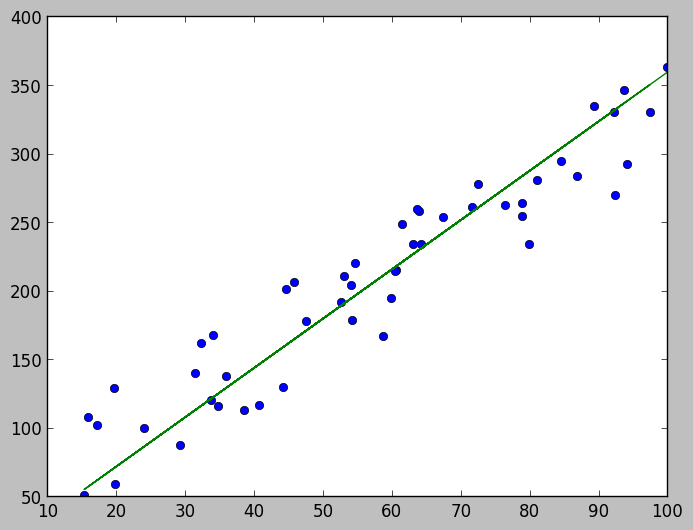

In [562]:
#Plot fitted line on top of old data
ys_est = slope_est * xs + intercept_est
fig, ax = plt.subplots()
ax.plot(xs, ys, 'o')
ax.plot(xs, ys_est)

And there you have it! We were able to find the equation to the line that best fits the data!

## Dimensionality Reduction
#### The Curse of Dimensionality
>Although the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality) is a broad term, the gist is that, when the dimensionality of a dataset increases, the volume of the space increases so fast that the available data become sparse. This sparsity is problematic for any analytic method that requires statistical significance. In order to obtain a statistically sound and reliable result, the amount of data needed to support the result often grows exponentially with the dimensionality. Also, organizing and searching data often relies on detecting areas where observations form groups with similar properties; in high dimensional data, however, all objects appear to be sparse and dissimilar in many ways, which prevents common data organization strategies from being efficient.

>The SVD alleviates the curse of dimensionality because, if $\bs{A}$ is $m \times n$ ($m$ rows and $n$ columns), $\bs{U}$  will be  $m \times m$,  $\bs{\Sigma}$  will be $m \times n$ and $\bs{V}$ will be $n \times n$. However, there are only  $r=rank(A)$ non-zero values in $\bs{\Sigma}$, i.e. $\sigma_1,\cdots,\sigma_r≠0; \sigma_{r+1},\cdots,\sigma_n=0$. (You can read up on what a matrix's rank is [here](http://stattrek.com/matrix-algebra/matrix-rank.aspx)). The takeaway is that the columns of $\bs{U}$ beyond the $r^{th}$ column and rows of $\bs{V}$ beyond the $r^{th}$ row do not contribute to $\bs{A}$ and are usually best omitted, leaving $\bs{U}$ an $m \times r$ matrix, $\bs{\Sigma}$ an $r \times r$  diagonal matrix and $\bs{V}$ an $r \times n$  matrix. 

>In practice, this means you can use the SVD to remove columns from a dataset that do not contribute to building a strong model.

So let's see an application of SVD to a very sparse dataset, one in which we're analyzing word frequency in documents in order to classify them as similar or not. For our documents, we'll be using a few sections from NAFTA and the scripts from the first three episodes of Friends.

In [563]:
#import a list of stopwords (common enlish words that we'll immediately nix from out word list)
files_path = os.path.join(os.getcwd(),'files')
with open(os.path.join(files_path,'stopwords.txt')) as f:
    stopwords = f.readlines()
    stopwords = set([x.rstrip() for x in stopwords])  # use a set for fast membership testing

In [564]:
def word_count(file):
    """Return a collections.Counter instance counting
    the words in a text file. Also returns the book name."""
    with open(file) as f:
        file_content = f.read()
        words = re.split(r'\W+', file_content.lower())
        words = [word for word in words if len(word) > 3 and word not in stopwords]
        word_count = collections.Counter(words)
    return word_count, os.path.basename(file)

In [565]:
files = ['friends1.txt','friends2.txt','friends3.txt','nafta1.txt','nafta2.txt','nafta3.txt','nafta4.txt']
word_df = pd.DataFrame()
dfs = []

for f in files:
    file = os.path.join(files_path,f)
    word_counter, book_name = word_count(file)
    file_df = pd.DataFrame.from_dict(word_counter,orient='index')
    dfs.append(file_df)
    file_df.columns = [book_name]
    #normalize word count by the total number of words in the file:
    file_df.ix[:, 0] = file_df.values.flatten() / float(file_df.values.sum())
    word_df = word_df.join(file_df, how='outer', )
    
word_df = word_df.fillna(0)
print("Number of unique words: %s" % len(word_df))

Number of unique words: 2519


Here are the word frequencies for each file, sorted by the most common words in the first file:

In [566]:
word_df.sort_values(by=word_df.columns[0], ascending=False).head(10)

,friends1.txt,friends2.txt,friends3.txt,nafta1.txt,nafta2.txt,nafta3.txt,nafta4.txt
okay,0.024803,0.000000,0.034277,0.000000,0.000000,0.0,0.000000
paul,0.023675,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
yeah,0.016911,0.000000,0.031297,0.000000,0.000000,0.0,0.000000
look,0.011274,0.000984,0.004471,0.000000,0.000000,0.0,0.000000
sorry,0.011274,0.000000,0.011923,0.000000,0.000000,0.0,0.000000
gonna,0.010147,0.000000,0.013413,0.000000,0.000000,0.0,0.000000
date,0.010147,0.000000,0.001490,0.001506,0.006944,0.0,0.000474
coffee,0.009019,0.000000,0.001490,0.000000,0.000000,0.0,0.000000
maybe,0.009019,0.000000,0.002981,0.000000,0.000000,0.0,0.000000
mean,0.009019,0.000984,0.013413,0.000000,0.000000,0.0,0.000947


Now to calculate the singular value decomposition of this data.

In [567]:
U, Sigma, V = np.linalg.svd(word_df)

Here is a look at $\bs{V}$, with the column names added:

In [568]:
v_df = pd.DataFrame(V, columns=word_df.columns)
v_df.apply(lambda x: np.round(x, decimals=2))

,friends1.txt,friends2.txt,friends3.txt,nafta1.txt,nafta2.txt,nafta3.txt,nafta4.txt
0,-0.00,-0.01,-0.01,-0.66,-0.59,-0.33,-0.32
1,0.56,0.04,0.83,-0.02,-0.01,0.01,0.02
2,0.02,-0.02,0.02,0.56,-0.00,-0.73,-0.40
3,-0.01,0.01,0.01,0.45,-0.61,0.54,-0.35
4,0.06,-0.01,-0.03,-0.22,0.52,0.26,-0.78
5,-0.83,0.01,0.56,-0.02,0.04,0.01,-0.06
6,0.01,-1.00,0.04,0.00,-0.01,0.02,0.01


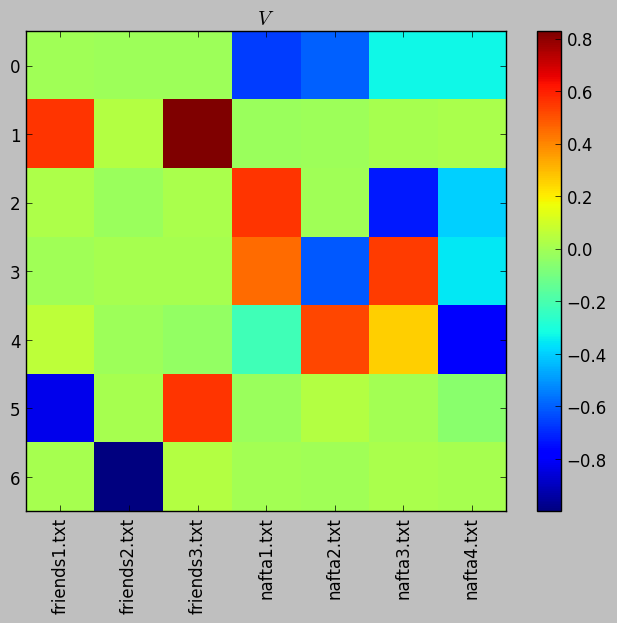

In [569]:
plt.imshow(V, interpolation='none')
ax = plt.gca()
plt.xticks(range(len(v_df.columns.values)))
plt.yticks(range(len(v_df.index.values)))
plt.title("$V$")
ax.set_xticklabels(v_df.columns.values, rotation=90)
plt.colorbar()

In the matrix above, note all the instances where the files have similar colors. For instance, the Friends files are all a greenish color in rows 0, 2, 3 and 4. For those same rows, the NAFTA files are mostly different (non-greenish) colors. In terms of comparing the papers, singular value decomposition allowed us to reduce the $2519$ different words found in the files into 6 values that are pre-sorted in order of importance!

# Conclusion
The singular value decomposition (SVD) is ubiquitous in machine learning. Here, we saw its application towards data compresion, fitting a line to data, and reducing the dimensionality of a sparse dataset.

In a coming lesson, we'll see another method of dimensionality reduction known as Principal Component Analysis (PCA).

But in the next chapter, we'll introduce ourselves to something called the pseudo-inverse.